In [1]:
import pandas as pd
import time
import numpy as np
from tqdm import tqdm_notebook as tqdm
from numpy import dot, array
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
import cvxopt
import math

In [2]:
def dimensionality_reduction(X_data,Y_label,save=False):
    meanVector = np.mean(X_data,axis = 0)
    centeredX_data = X_data - meanVector
    sdVector = np.std(centeredX_data.astype(float),axis = 0)
    for index,value in enumerate(sdVector):
      if value <= 1e-5:
          sdVector[index] = 1.0  
        
    centeredX_data /= sdVector
    
    covX_data = np.array([centeredX_data[0,:]]).T@ np.array([centeredX_data[0,:]])
    for i in range(1,len(centeredX_data)):
        covX_data += np.array([centeredX_data[i,:]]).T@ np.array([centeredX_data[i,:]])
    covX_data /= len(covX_data)

    eigenValues, eigenVectors = np.linalg.eig(covX_data)
    idx = eigenValues.argsort()[::-1] 
    eigenVectors = eigenVectors[:,idx]

    neededEigenVectors = []
    for idx, val in enumerate(eigenValues):
        if (sum(eigenValues[0:idx])/sum(eigenValues))>0.7:
            neededEigenVectors = eigenVectors[:,0:idx]
            break

    reconstructX_data = centeredX_data@neededEigenVectors
    print('reduced dimensions are ')
    print(reconstructX_data.shape)
    return reconstructX_data

In [3]:
def normsquare(a,b):    
    a_min_b = a - b
    return sum((a - b)**2)
    #return (np.sum(np.square(a_min_b)))
    #return np.einsum('ij,ij->i', a_min_b, a_min_b)

In [4]:
class SMCSVM:
    def __init__(self):
        self.kernel = 'rbf'
        self.C=10
        self.degree = 1
        self.sigma=1.0
        self.alphas2=None
        self.fullXmatrix=None
        self.IntermXmatrix=None
        self.train_X_data = None
        self.num_classes = None
    
    def fit(self, X_data, Y_label,C=10,kernel='rbf',degree=1,sigma=1.0):
        self.kernel = kernel
        self.C= C
        self.degree = degree
        self.sigma= sigma 
        self.train_X_data = X_data
        X = X_data
        trainLabelVector = Y_label
        #fullXmatrix =[]
        num_classes = len(np.unique(Y_label))
        self.num_classes = num_classes
        #print(trainLabelVector.shape)

        fullXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes*((X_data.shape[1])+1)))

        #for i in tqdm(range(0,(X_data.shape[0]*(num_class-1)))):

        count5 = 0
        print('\n Calculating fullXmatrix')
        for i in tqdm(range(0,X.shape[0])):
            for p in range(0,num_classes):
                if(trainLabelVector[i]!=p):   
                    for j in range(0,num_classes):
                        if(j==trainLabelVector[i]):
                            fullXmatrix[count5,(j*(X_data.shape[1]+1)):((j+1)*(X_data.shape[1]+1))-1] = X[i,:]
                            fullXmatrix[count5,((j+1)*(X_data.shape[1]+1))-1] = 1.0
                        elif(j==p):
                            fullXmatrix[count5,(j*(X_data.shape[1]+1)):((j+1)*(X_data.shape[1]+1))-1] = -1*X[i,:]
                            fullXmatrix[count5,((j+1)*(X_data.shape[1]+1))-1] = -1.0
                    count5 += 1
                    #print(count5)
        #print(fullXmatrix.shape)
        m = fullXmatrix.shape[0]
        M1 = sparse.csr_matrix(fullXmatrix) 
        IntermXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes))
        #if(kernel=='polynomial'):   
        #    H = sparse.csr_matrix.dot(M1,M1.T) 
        #    H = (1+H.todense())**degree   
            #H,IntermXmatrix = self.getKernelizedProduct(X_data,Y_label,kernel,sigma)
        if(kernel=='linear'):
            H = sparse.csr_matrix.dot(M1,M1.T)
        else:
            H,IntermXmatrix = self.getKernelizedProduct(X_data,Y_label,kernel,sigma,degree)        

        from cvxopt import matrix as cvxopt_matrix
        from cvxopt import solvers as cvxopt_solvers
        if(kernel=='linear'):
            P = cvxopt_matrix(H.todense())
        else:
            P = cvxopt_matrix(H)
        q = cvxopt_matrix(-1*np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        opts = {'maxiters' : 30,'solver':'mosek'}
        sol = cvxopt_solvers.qp(P, q, G, h ,options = opts)
        alphas2 = np.array(sol['x']) 
        #w = fullXmatrix.T@alphas2
        #wForEachLabel = {}
        #for i in range(0,num_classes):
            #wForEachLabel[i] = np.array_split(w,num_classes)[i]
        self.alphas2=alphas2
        self.fullXmatrix=fullXmatrix
        self.IntermXmatrix=IntermXmatrix
        
        #return alphas2,fullXmatrix,IntermXmatrix
    def predict(self,val_X_data):
    #def predict(train_X_data,val_X_data,IntermXmatrix,num_classes,alphas2,fullXmatrix,kernel,degree,sigma):
        num_classes = self.num_classes
        train_X_data = self.train_X_data
        kernel = self.kernel
        degree = self.degree
        sigma = self.sigma
        alphas2=self.alphas2
        fullXmatrix=self.fullXmatrix
        IntermXmatrix=self.IntermXmatrix

        predictedLabelVector = []
        if(kernel == 'linear'):
            w = fullXmatrix.T@alphas2
            wForEachLabel = {}
            for i in range(0,num_classes):
                wForEachLabel[i] = np.array_split(w,num_classes)[i]
            print('\n Calculating prediction values')
            for i in tqdm(range(0,val_X_data.shape[0])):
                scoresForEachLabel = []
                for j in range(0,len(wForEachLabel)):
                    score = (wForEachLabel[j].T@np.append(val_X_data[i,:],1.0).reshape(-1,1))
                    scoresForEachLabel.append(score)
                maxScoreLabel = np.argmax(scoresForEachLabel)
                predictedLabelVector.append(maxScoreLabel)
        elif(kernel == 'polynomial'):
            print('\n Calculating prediction values')
            for i in tqdm(range(0,val_X_data.shape[0])):
                #tempMatrix1 = np.zeros((num_classes*(val_X_data.shape[1]+1),num_classes))
                #for j in range(0,num_classes):
                #    tempMatrix1[j*(val_X_data.shape[1]+1):(j+1)*(val_X_data.shape[1]+1),j] = np.append(val_X_data[i,:],1.0)
                #scoresForEachLabel = (alphas2.T)@((1+(fullXmatrix@tempMatrix1))**degree)
                scoresForEachLabel = (alphas2.T)@(self.getKernelizedProductforPrediction(train_X_data,val_X_data,IntermXmatrix,i,num_classes,kernel,sigma,degree))
                maxScoreLabel = np.argmax(scoresForEachLabel)
                predictedLabelVector.append(maxScoreLabel)
        elif(kernel == 'rbf'):
            print('\n Calculating prediction values')
            for i in tqdm(range(0,val_X_data.shape[0])):
                #tempMatrix1 = np.zeros((num_classes*(val_X_data.shape[1]+1),num_classes))
                #for j in range(0,num_classes):
                    #tempMatrix1[j*(val_X_data.shape[1]+1):(j+1)*(val_X_data.shape[1]+1),j] = np.append(val_X_data[i,:],1.0)
                scoresForEachLabel = (alphas2.T)@(self.getKernelizedProductforPrediction(train_X_data,val_X_data,IntermXmatrix,i,num_classes,kernel,sigma,degree))
                maxScoreLabel = np.argmax(scoresForEachLabel)
                predictedLabelVector.append(maxScoreLabel)
        return predictedLabelVector
    def getKernelizedProductforPrediction(self,X_data,val_X_data,IntermXmatrix,currentValIndex,num_classes,kernel,sigma,degree):
        X = X_data
        m = (X_data.shape[0]*(num_classes-1))
        H = np.zeros((m,num_classes))    
        matrix2 = (currentValIndex+1)*np.eye(num_classes)
        tempCoeff = (1/(X.shape[1]+1))
        
        if(kernel == 'polynomial'): 
            for i in (range(0,m)):
                for j in range(0,num_classes):
                    count1 = 0
                    for k in range(0,num_classes):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            if(temp3>0):
                                count1+=1
                                if(temp4>0):                             
                                    H[i,j] += (1+((1/tempCoeff)*np.dot(np.append(X[temp3-1,:],1.0),np.append(val_X_data[temp4-1,:],1.0))))**degree
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += (1+((1/tempCoeff)*np.dot(np.append(val_X_data[temp4-1,:],1.0),np.append(-1*X[-temp3-1,:],-1.0))))**degree
        

        elif(kernel == 'rbf'): 
            for i in (range(0,m)):
                for j in range(0,num_classes):
                    count1 = 0
                    for k in range(0,num_classes):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            if(temp3>0):
                                count1+=1
                                if(temp4>0):                             
                                    H[i,j] += np.exp(-1*(np.linalg.norm(X[temp3-1,:]-val_X_data[temp4-1,:])**2)/(2*sigma**2))                        
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(np.append(val_X_data[temp4-1,:],1.0)-np.append(-1*X[-temp3-1,:],-1.0))**2)/(2*sigma**2))                    

        return H      
    def getKernelizedProduct(self,X_data,Y_label,kernel,sigma,degree):
        X = X_data
        trainLabelVector = Y_label
        num_classes = len(np.unique(Y_label))
        IntermXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes))
        count6 = 0
        m = (X_data.shape[0]*(num_classes-1))
        nonZeroColumnIndicesAndValuesInIntermXmatrix = []# np.zeros((m,4)) 
        print('\n Calculating Kernalized Product')
        
        for i in tqdm(range(0,X.shape[0])):
            for p in range(0,num_classes):
                if(trainLabelVector[i]!=p):   
                    tempArray = []
                    for j in range(0,num_classes):
                        if(j==trainLabelVector[i]):
                            tempArray.append(j)
                            tempArray.append(i+1)
                            IntermXmatrix[count6,j] = i+1
                        elif(j==p):
                            tempArray.append(j)
                            tempArray.append(-(i+1))
                            IntermXmatrix[count6,j] = -(i+1)
                    count6 += 1
                    nonZeroColumnIndicesAndValuesInIntermXmatrix.append(tempArray)
                    
        #nonZeroColumnIndicesAndValuesInIntermXmatrix = np.array(nonZeroColumnIndicesAndValuesInIntermXmatrix)
        matrix2 = IntermXmatrix.T
        M2 = scipy.sparse.coo_matrix(IntermXmatrix)
        M3 = scipy.sparse.coo_matrix(IntermXmatrix.T)
        m = (X_data.shape[0]*(num_classes-1))
        H = np.zeros((m,m))
        tempCoeff = (1/(X.shape[1]+1))
        #tempCoeff = 2
        
        
        if(kernel == 'rbf'):
            matrix2 = matrix2.tolist()
            #X = X.tolist()
            print('\n Calculating Kernalized Product')
            for i in tqdm(range(0,m)):
                for j in range(0,i+1):
                    #nonZeroColumnIndicesAndValuesInIntermXmatrix[i][0]
                    #nonZeroIndicesLocation = np.nonzero(IntermXmatrix[i,:])
                    #temp8 = IntermXmatrix[i,:][nonZeroIndicesLocation][0]
                    temp8 = nonZeroColumnIndicesAndValuesInIntermXmatrix[i][1]
                    #temp9 = IntermXmatrix[i,:][nonZeroIndicesLocation][1]
                    temp9 =nonZeroColumnIndicesAndValuesInIntermXmatrix[i][3]
                    #locOftemp8 = nonZeroIndicesLocation[0]
                    locOftemp8 = nonZeroColumnIndicesAndValuesInIntermXmatrix[i][0]
                    #locOftemp9 = nonZeroIndicesLocation[1]
                    locOftemp9 = nonZeroColumnIndicesAndValuesInIntermXmatrix[i][2]
                    temp10 = matrix2[locOftemp8][j]
                    temp11 = matrix2[locOftemp9][j]
                    #temp10zero = 1
                    #temp11zero = 1
                    #if(temp10 == 0):
                        #temp10zero = 0
                    #if(temp11 == 0):
                        #temp11zero = 0
                    temp8Pos = 1
                    temp9Pos = 1
                    temp10Pos = 1
                    temp11Pos = 1
                    
                    if(temp8 < 0):
                        temp8Pos = -1
                    if(temp9 < 0):
                        temp9Pos = -1
                    if(temp10 < 0):
                        temp10Pos = -1
                    if(temp11 < 0):
                        temp11Pos = -1
                        
                    if(temp10 != 0):
                        #H[i,j] += (2.718281828459045)**(-1*normsquare(np.append(temp8Pos*X[int(temp8Pos*temp8)-1,:],temp8Pos),np.append(temp10Pos*X[int(temp10Pos*temp10)-1,:],temp10Pos))/(2*sigma**2))                       
                        H[i,j] += (2.718281828459045)**(-1*(np.linalg.norm(np.append(temp8Pos*X[int(temp8Pos*temp8)-1,:],temp8Pos)-np.append(temp10Pos*X[int(temp10Pos*temp10)-1,:],temp10Pos))**2)/(2*sigma**2))
                    if(temp11 != 0):
                        #H[i,j] += (2.718281828459045)**(-1*normsquare(np.append(temp9Pos*X[int(temp9Pos*temp9)-1,:],temp9Pos),np.append(temp11Pos*X[int(temp11Pos*temp11)-1,:],temp11Pos))/(2*sigma**2))
                        H[i,j] += (2.718281828459045)** (-1*(np.linalg.norm(np.append(temp9Pos*X[int(temp9Pos*temp9)-1,:],temp9Pos)-np.append(temp11Pos*X[int(temp11Pos*temp11)-1,:],temp11Pos))**2)/(2*sigma**2))    

        
        elif(kernel == 'polynomial'):
            print('\n Calculating Kernalized Product')
            for i in tqdm(range(0,m)):
                for j in range(0,i+1):
                    count1 = 0
                    #count2 = 0
                    for k in range(0,IntermXmatrix.shape[1]):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            #print(temp3,temp4)
                            if(temp3>0):
                                count1+=1
                                if(temp4>0): 
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(X[temp3-1,:],1.0),np.append(X[temp4-1,:],1.0))))**degree)
                                elif(temp4<0):                                    
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(X[temp3-1,:],1.0),np.append(-1*X[-temp4-1,:],-1.0))))**degree)
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(X[temp4-1,:],1.0),np.append(-1*X[-temp3-1,:],-1.0))))**degree)
                                elif(temp4<0):
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(-1*X[-temp4-1,:],-1.0),np.append(-1*X[-temp3-1,:],-1.0))))**degree)
              

        elif(kernel == 'kartheek'):
            print('\n Calculating Kernalized Product')
            for i in tqdm(range(0,m)):
                for j in range(0,i+1):
                    count1 = 0
                    #count2 = 0
                    for k in range(0,IntermXmatrix.shape[1]):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            #print(temp3,temp4)
                            if(temp3>0):
                                count1+=1
                                if(temp4>0):                             
                                    H[i,j] += np.exp(-1*(np.linalg.norm(X[temp3-1,:]-X[temp4-1,:])**2)/(2*sigma**2))
                                elif(temp4<0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(np.append(X[temp3-1,:],1.0)-np.append(-1*X[-temp4-1,:],-1.0))**2)/(2*sigma**2))
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(np.append(X[temp4-1,:],1.0)-np.append(-1*X[-temp3-1,:],-1.0))**2)/(2*sigma**2))                    
                                elif(temp4<0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(-1*X[-temp3-1,:]+X[-temp4-1,:])**2)/(2*sigma**2))
        print('\n Calculating Kernalized Product')
        for i in tqdm(range(0,m)):
            for j in range(0,i+1):
                if(j>i):
                    H[i,j]=H[j,i]                 
        #print(H.shape)        

        return H,IntermXmatrix

WINE DATASET

In [5]:
from sklearn.datasets import load_wine
Givendata = load_wine()
ran = np.random.rand(len(Givendata['data'])) < 0.8
train_X_data = Givendata['data'][ran]
train_Y_data = Givendata['target'][ran]
val_X_data = Givendata['data'][~ran]
val_Y_data = Givendata['target'][~ran]
kernel = 'rbf'
degree = 4
sigma = 0.4
C = 10
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
conMatrix


 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.4472e+03 -4.9364e+03  6e+03  3e-17  1e-15
 1:  1.6230e+02 -4.8632e+02  6e+02  1e-16  2e-15
 2: -3.2852e+01 -1.2128e+02  9e+01  1e-16  6e-16
 3: -4.7440e+01 -5.4771e+01  7e+00  9e-17  2e-16
 4: -4.7667e+01 -4.7769e+01  1e-01  3e-16  1e-16
 5: -4.7667e+01 -4.7668e+01  1e-03  1e-16  2e-16
 6: -4.7667e+01 -4.7667e+01  1e-05  1e-16  1e-16
Optimal solution found.

 Time taken for training in seconds:  2.550504446029663

 Calculating prediction values


col_0,0,1,2
row_0,,,
0,47,0,0
1,0,62,0
2,0,0,34


IRIS DATASET

In [101]:
from sklearn.datasets import load_iris
Givendata =load_iris()
ran = np.random.rand(len(Givendata['data'])) < 0.8
train_X_data = Givendata['data'][ran]
train_Y_data = Givendata['target'][ran]
val_X_data = Givendata['data'][~ran]
val_Y_data = Givendata['target'][~ran]
kernel = 'rbf'
degree = 4
sigma = 0.4
C = 10
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
conMatrix


 Calculating fullXmatrix



 Calculating Kernalized Product



 Calculating Kernalized Product



 Calculating Kernalized Product


     pcost       dcost       gap    pres   dres
 0:  4.4085e+02 -5.2741e+03  1e+04  2e-01  3e-15
 1:  2.4681e+02 -5.0963e+02  8e+02  6e-03  2e-15
 2:  2.6505e+01 -7.4044e+01  1e+02  2e-16  3e-15
 3: -4.5001e+00 -1.7929e+01  1e+01  2e-16  1e-15
 4: -7.1782e+00 -8.7972e+00  2e+00  2e-16  4e-16
 5: -7.5109e+00 -7.9163e+00  4e-01  2e-16  2e-16
 6: -7.6333e+00 -7.7414e+00  1e-01  1e-16  2e-16
 7: -7.6661e+00 -7.6821e+00  2e-02  2e-16  2e-16
 8: -7.6713e+00 -7.6723e+00  1e-03  2e-16  2e-16
 9: -7.6717e+00 -7.6717e+00  2e-05  2e-16  2e-16
10: -7.6717e+00 -7.6717e+00  5e-07  2e-16  2e-16
Optimal solution found.

 Time taken for training in seconds:  2.06280779838562

 Calculating prediction values


col_0,0,1,2
row_0,,,
0,42,0,0
1,0,37,3
2,0,1,38


In [6]:
def plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=1):
  
   markers = ('s', 'x', 'o', '^', 'v')
   colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  
   cmap = ListedColormap(colors[:len(np.unique(train_Y_data))])

   MinFirstAttr, MaxFirstAttr = train_X_data[:, 0].min() - 1 , train_X_data[:, 0].max() + 1
    
   MinSecAttr,MaxSecAttr = train_X_data[:, 1].min() - 1, train_X_data[:, 1].max() + 1
   MeshGridPtsFirstAttr, MeshGridPtsSecAttr = np.meshgrid(np.arange(MinFirstAttr, MaxFirstAttr, resolution),np.arange(MinSecAttr, MaxSecAttr, resolution))
   print(MeshGridPtsFirstAttr.ravel().shape)
   print(MeshGridPtsSecAttr.ravel().shape)
   Z = classifier.predict(np.array([MeshGridPtsFirstAttr.ravel(), MeshGridPtsSecAttr.ravel()]).T)
   Z = np.array(Z) 
   Z = Z.reshape(MeshGridPtsFirstAttr.shape)
   plt.contourf(MeshGridPtsFirstAttr, MeshGridPtsSecAttr, Z, alpha=0.1, cmap=cmap)
   plt.xlim(MeshGridPtsFirstAttr.min(), MeshGridPtsFirstAttr.max())
   plt.ylim(MeshGridPtsSecAttr.min(), MeshGridPtsSecAttr.max())
   for index, cl in enumerate(np.unique(train_Y_data)):
      plt.scatter(x=train_X_data[train_Y_data == cl, 0], y=train_X_data[train_Y_data == cl, 1],alpha=0.8, c=cmap(index),marker=markers[index], label=cl)
   plt.legend(loc='upper left')
   plt.show()

In [36]:
train_Y_data.shape

(84,)


 Calculating fullXmatrix



 Calculating Kernalized Product



 Calculating Kernalized Product



 Calculating Kernalized Product


     pcost       dcost       gap    pres   dres
 0:  4.5598e+04 -1.9117e+05  3e+05  3e-02  3e-14
 1:  1.0164e+04 -1.4632e+04  3e+04  9e-04  4e-14
 2:  1.4359e+03 -1.7976e+03  3e+03  2e-16  2e-14
 3:  1.7910e+02 -2.8647e+02  5e+02  2e-16  9e-15
 4:  1.3101e+01 -5.2343e+01  7e+01  2e-16  3e-15
 5: -5.5028e+00 -1.3877e+01  8e+00  2e-16  9e-16
 6: -6.7720e+00 -7.5172e+00  7e-01  2e-16  3e-16
 7: -6.9203e+00 -7.0980e+00  2e-01  1e-16  2e-16
 8: -6.9770e+00 -7.0132e+00  4e-02  1e-16  2e-16
 9: -6.9910e+00 -6.9928e+00  2e-03  2e-16  2e-16
10: -6.9917e+00 -6.9919e+00  1e-04  2e-16  2e-16
11: -6.9918e+00 -6.9918e+00  5e-06  2e-16  2e-16
Optimal solution found.

 Time taken for training in seconds:  1.3242363929748535

 Calculating prediction values


(4745,)
(4745,)

 Calculating prediction values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


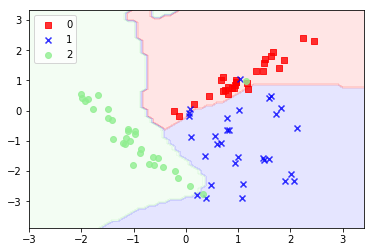

In [64]:
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3)
#X1, Y1 = make_blobs(n_features=2, centers=3)
#X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
ran = np.random.rand(len(X1)) < 0.8
train_X_data = X1[ran]
train_Y_data = Y1[ran]
val_X_data = X1[~ran]
val_Y_data = Y1[~ran]
kernel = 'rbf'
degree = 4
sigma = 0.4
C = 100
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
conMatrix
classifier = a1
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)


 Calculating fullXmatrix



 Calculating Kernalized Product



 Calculating Kernalized Product



 Calculating Kernalized Product


     pcost       dcost       gap    pres   dres
 0:  4.5050e+04 -1.8653e+05  3e+05  2e-02  3e-14
 1:  9.6986e+03 -1.4068e+04  2e+04  8e-04  4e-14
 2:  1.3589e+03 -1.7273e+03  3e+03  2e-16  2e-14
 3:  1.6668e+02 -2.7724e+02  4e+02  2e-16  8e-15
 4:  1.0437e+01 -5.1747e+01  6e+01  2e-16  3e-15
 5: -6.6313e+00 -1.4424e+01  8e+00  2e-16  9e-16
 6: -7.6978e+00 -8.4055e+00  7e-01  2e-16  3e-16
 7: -7.7931e+00 -7.9737e+00  2e-01  2e-16  2e-16
 8: -7.8296e+00 -7.8685e+00  4e-02  2e-16  2e-16
 9: -7.8406e+00 -7.8433e+00  3e-03  2e-16  2e-16
10: -7.8413e+00 -7.8414e+00  8e-05  1e-16  2e-16
11: -7.8413e+00 -7.8413e+00  2e-06  2e-16  2e-16
Optimal solution found.

 Time taken for training in seconds:  1.1193370819091797

 Calculating prediction values


col_0   0   1   2
row_0            
0      28   0   0
1       1  26   0
2       0   0  20
(5040,)
(5040,)

 Calculating prediction values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


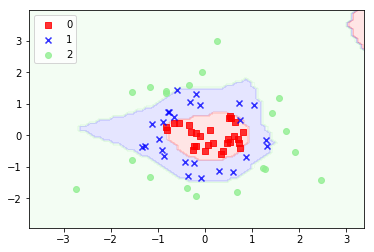

In [39]:
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3)
#X1, Y1 = make_blobs(n_features=2, centers=3)
X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
ran = np.random.rand(len(X1)) < 0.8
train_X_data = X1[ran]
train_Y_data = Y1[ran]
val_X_data = X1[~ran]
val_Y_data = Y1[~ran]
kernel = 'rbf'
degree = 4
sigma = 0.4
C = 100
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
print(conMatrix)
classifier = a1
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)


 Calculating fullXmatrix


     pcost       dcost       gap    pres   dres
 0:  2.9261e+08 -9.3939e+11  2e+12  5e-01  7e-09
 1:  4.3392e+08 -1.4010e+11  3e+11  5e-02  2e-08
 2:  3.5698e+08 -6.5678e+09  1e+10  2e-03  1e-09
 3:  2.0340e+08 -2.7091e+08  5e+08  2e-05  1e-10
 4:  3.2013e+07 -3.4666e+07  7e+07  2e-16  5e-11
 5:  4.5888e+06 -5.0521e+06  1e+07  2e-16  3e-11
 6:  6.5748e+05 -7.2279e+05  1e+06  2e-16  1e-11
 7:  9.4186e+04 -1.0362e+05  2e+05  2e-16  4e-12
 8:  1.3485e+04 -1.4859e+04  3e+04  2e-16  2e-12
 9:  1.9282e+03 -2.1335e+03  4e+03  2e-16  6e-13
10:  2.7468e+02 -3.0735e+02  6e+02  2e-16  2e-13
11:  3.8737e+01 -4.4662e+01  8e+01  2e-16  1e-13
12:  5.3045e+00 -6.6409e+00  1e+01  2e-16  3e-14
13:  6.5581e-01 -1.0498e+00  2e+00  2e-16  1e-14
14:  4.1164e-02 -1.9616e-01  2e-01  2e-16  5e-15
15: -1.2474e-02 -1.1420e-01  1e-01  2e-16  2e-15
16: -3.7029e-02 -1.1426e-01  8e-02  2e-16  1e-15
17: -5.3252e-02 -1.1604e-01  6e-02  2e-16  1e-15
18: -7.5030e-02 -8.4514e-02  9e-03  2e-16  2e-15
19: -7.9116e-02 -7.98

col_0   0   1   2   3
row_0                
0      17   0   0   0
1       0  19   0   0
2       0   0  20   0
3       0   0   0  22
(39246,)
(39246,)

 Calculating prediction values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

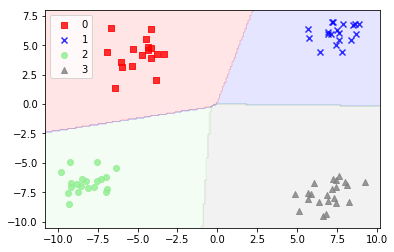

In [51]:
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3)
X1, Y1 = make_blobs(n_features=2, centers=4)
#X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
ran = np.random.rand(len(X1)) < 0.8
train_X_data = X1[ran]
train_Y_data = Y1[ran]
val_X_data = X1[~ran]
val_Y_data = Y1[~ran]
kernel = 'linear'
degree = 4
sigma = 0.4
C = 100000
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
print(conMatrix)
classifier = a1
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)


 Calculating fullXmatrix


     pcost       dcost       gap    pres   dres
 0:  1.1451e+10 -5.7944e+11  1e+12  4e-01  7e-09
 1:  1.0319e+10 -1.3426e+11  2e+11  7e-02  5e-08
 2:  3.2953e+09 -6.0202e+10  1e+11  3e-02  2e-08
 3:  5.6832e+08 -8.1642e+09  2e+10  4e-03  3e-09
 4:  2.9437e+08 -5.3583e+08  1e+09  1e-04  5e-10
 5:  5.3572e+07 -5.7954e+07  1e+08  2e-07  8e-11
 6:  7.6953e+06 -8.5064e+06  2e+07  2e-16  4e-11
 7:  1.1027e+06 -1.2139e+06  2e+06  2e-16  1e-11
 8:  1.5793e+05 -1.7398e+05  3e+05  2e-16  7e-12
 9:  2.2595e+04 -2.4961e+04  5e+04  2e-16  3e-12
10:  3.2238e+03 -3.5906e+03  7e+03  2e-16  9e-13
11:  4.5641e+02 -5.1992e+02  1e+03  2e-16  3e-13
12:  6.3041e+01 -7.6676e+01  1e+02  2e-16  1e-13
13:  7.7405e+00 -1.1996e+01  2e+01  2e-16  5e-14
14:  1.5752e+00 -6.8001e+00  8e+00  2e-16  4e-14
15: -2.5559e+00 -4.6128e+00  2e+00  2e-16  5e-14
16: -3.0931e+00 -3.8920e+00  8e-01  2e-16  5e-14
17: -3.2068e+00 -3.7845e+00  6e-01  2e-16  5e-14
18: -3.3941e+00 -3.4406e+00  5e-02  2e-16  6e-14
19: -3.4147e+00 -3.41

col_0   0   1   2
row_0            
0      26   0   0
1       0  29   0
2       0   0  30
(22042,)
(22042,)

 Calculating prediction values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


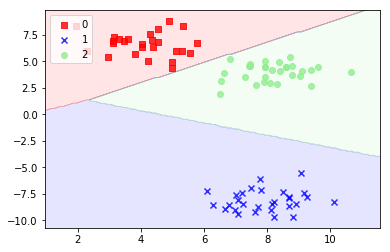

In [67]:
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3)
X1, Y1 = make_blobs(n_features=2, centers=3)
#X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
ran = np.random.rand(len(X1)) < 0.8
train_X_data = X1[ran]
train_Y_data = Y1[ran]
val_X_data = X1[~ran]
val_Y_data = Y1[~ran]
kernel = 'linear'
degree = 4
sigma = 0.4
C = 100000
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
print(conMatrix)
classifier = a1
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)

col_0   0   1   2
row_0            
0      26   0   0
1       0  29   0
2       0   0  30
(22042,)
(22042,)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


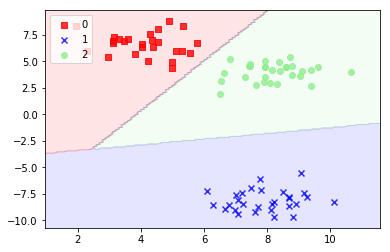

In [69]:
from sklearn import svm
clf = svm.SVC(gamma=1, decision_function_shape='ovo',kernel='linear',degree = 1,C=100000)
clf.fit(train_X_data, train_Y_data) 
predictedLabelVector = []
GivenData = train_X_data
GivenDataLabels = train_Y_data
for i in tqdm(range(0,len(GivenData))):
    predictedLabelVector.append(clf.predict(GivenData[i,:].reshape(1,train_X_data.shape[1])))
conMatrix = pd.crosstab(np.array(predictedLabelVector).ravel(),GivenDataLabels.reshape(-1,1).ravel())
print(conMatrix)
classifier = clf 
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)

C:\Users\sravani\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


col_0   0   1   2
row_0            
0      26   0   0
1       0  29   0
2       0   0  30
(22042,)
(22042,)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


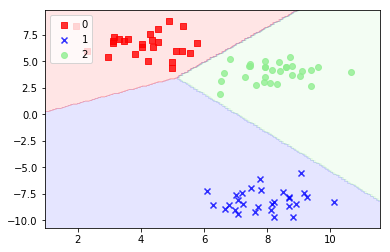

In [70]:
lin_clf = svm.LinearSVC()
lin_clf.C =100000
lin_clf.kernel='poly'
lin_clf.gamma=1
lin_clf.degree=4
lin_clf.max_iter=10**5
lin_clf.fit(train_X_data, train_Y_data) 
predictedLabelVector = []
GivenData = train_X_data
GivenDataLabels = train_Y_data
for i in tqdm(range(0,len(GivenData))):
    predictedLabelVector.append(lin_clf.predict(GivenData[i,:].reshape(1,train_X_data.shape[1])))
conMatrix = pd.crosstab(np.array(predictedLabelVector).ravel(),GivenDataLabels.reshape(-1,1).ravel())
print(conMatrix)
classifier = lin_clf 
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)


 Calculating fullXmatrix



 Calculating Kernalized Product



 Calculating Kernalized Product



 Calculating Kernalized Product


     pcost       dcost       gap    pres   dres
 0:  2.4050e+01 -2.7437e+04  6e+04  2e-02  2e-08
 1:  4.8881e+00 -5.6894e+02  1e+03  5e-04  2e-08
 2:  1.1649e+00 -5.2301e+01  1e+02  4e-05  2e-09
 3:  1.7412e-01 -7.6385e+00  1e+01  5e-06  2e-10
 4:  5.1162e-02 -1.0770e+00  2e+00  6e-07  2e-11
 5:  1.5291e-02 -1.4433e-01  2e-01  6e-08  3e-12
 6:  4.2509e-03 -2.2097e-02  4e-02  7e-09  4e-13
 7:  1.1069e-03 -3.0637e-03  5e-03  7e-10  1e-13
 8:  1.9299e-04 -2.5985e-04  5e-04  5e-12  6e-14
 9:  2.0574e-05 -4.3978e-05  6e-05  2e-16  2e-14
10: -1.2101e-06 -1.2039e-05  1e-05  2e-16  1e-14
11: -5.8993e-06 -1.0300e-05  4e-06  2e-16  6e-15
12: -7.6413e-06 -8.4081e-06  8e-07  2e-16  6e-15
13: -7.8679e-06 -8.1962e-06  3e-07  2e-16  6e-15
14: -7.9386e-06 -8.0789e-06  1e-07  2e-16  6e-15
15: -7.9918e-06 -7.9963e-06  4e-09  2e-16  8e-15
Optimal solution found.

 Time taken for training in seconds:  0.8484921455383301

 Calculating prediction values


col_0   0   1   2
row_0            
0      22   1   0
1       4  26   0
2       0   0  31
(2695,)
(2695,)

 Calculating prediction values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


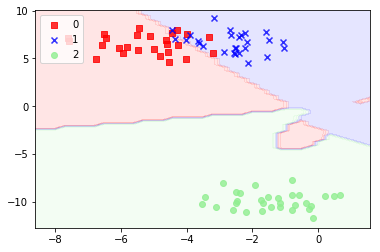

In [63]:
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3)
X1, Y1 = make_blobs(n_features=2, centers=3)
#X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
ran = np.random.rand(len(X1)) < 0.8
train_X_data = X1[ran]
train_Y_data = Y1[ran]
val_X_data = X1[~ran]
val_Y_data = Y1[~ran]
kernel = 'polynomial'
degree = 3
sigma = 0.4
C = 100
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
print(conMatrix)
classifier = a1
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.3)

In [61]:
def performCrossValidation(X1,Y1,num_folds,classifier,kernel='rbf',degree=1,sigma=1.0):
    C = 10
    fullXmatrix1 = X1
    fullYvector1 = Y1
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=num_folds)
    kf.get_n_splits(fullXmatrix1)
    consideredSigmaValues = [0.1,0.3,0.4,0.5,0.6,0.7,1.0]
    consideredCValues = [0,50,100]
    consideredKernelValues = ['linear','polynomial','rbf']
    fig, ax = plt.subplots(figsize=(15,10))
    for kernel in consideredKernelValues:
        for C in consideredCValues:
            crossValAvgErrorForEachSigma = []
            crossValVarOfErrorForEachSigma = []
            
            for sigma in consideredSigmaValues:#, 1e-4 ,1e-3, 1e-2, 0.1, 1, 10, 100 ,1000]:
                ValErrorForEachFold = []
                fold = 0
                for train_index, test_index in kf.split(fullXmatrix1):
                    print('fold is '+str(fold))
                    fold += 1
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = fullXmatrix1[train_index], fullXmatrix1[test_index]
                    y_train, y_test = fullYvector1[train_index], fullYvector1[test_index]
                    trainXmatrix = X_train
                    ValXmatrix = X_test
                    trainYvector = y_train
                    valYvector = y_test
                    numOfSamples,numOfdimPlusOne = trainXmatrix.shape
                    classifier.fit(X_train, y_train,C,kernel,degree,sigma)
                    #classifier.fit(X_train, y_train,lamda,kernel,degree,sigma)
                    #classifier.fit(X_train, y_train,C,lamda,degree,sigma)
                    predictedLabels = classifier.predict(X_test)
                    numOfCorrectlyPredictedLabels = 0
                    for index in range(0,len(valYvector)):
                        if(valYvector[index] == predictedLabels[index]):
                            numOfCorrectlyPredictedLabels += 1
                    accuracy = numOfCorrectlyPredictedLabels/len(valYvector)
                    error = 1- accuracy
                    ValErrorForEachFold.append(error)
                crossValAvgErrorForEachSigma.append(np.mean(ValErrorForEachFold))
                crossValVarOfErrorForEachSigma.append(np.std(ValErrorForEachFold))
            
            #for i in numOfdimPlusOne:#[:-1]
            #for i in lamdavalues:
            #ax.plot(np.arange(0.8,0.91,0.01),crossValAvgErrorForEachLamda, label= 'Bias Estimate')
            ax.plot(consideredSigmaValues,crossValAvgErrorForEachSigma, label= 'Bias Estimate for Kernel= '+str(kernel)+'C='+str(C))
            ax.plot(consideredSigmaValues,crossValVarOfErrorForEachSigma, label= 'Variance Estimate for Kernel= '+str(kernel)+'C='+str(C))
            if((len(consideredKernelValues)==1) and (len(consideredCValues)==1) and (len(consideredSigmaValues)==1)):
                print('cross validation error estimate is '+str(crossValAvgErrorForEachSigma))
            ax.legend(loc=0) # upper left corner
            ax.set_xlabel('Sigma')
            ax.set_ylabel('values')
            ax.set_title('(using cross validation) Bias & Variance Estimate for different hyperparameter values');
    plt.show()

In [ ]:
x = np.array([3, 0, 0, 5, 8])
x
t = np.nonzero(x)
x[t][2]

In [ ]:
x = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
x[2,:]

In [71]:
newReconstructedData = pd.read_csv('ReconstructedApparelData.csv',sep=',',index_col = False)

In [96]:
trainingTimeTakenOVR = []
#UniqueLabels=np.array([0,1,2,3,4,5,6,7,8,9])
for count007 in range(2,10):
    UniqueLabels=np.array(range(0,count007))
    DataPerClass = []
    index = 0
    for i in UniqueLabels:
        tempdf = newReconstructedData.loc[newReconstructedData['label'] == i]
        DataPerClass.append(tempdf.sample(frac = 0.009))
        print(len(DataPerClass[index]))#+str(" for ")+str(i))
        index = index + 1
    num_classes = len(UniqueLabels)
    train = {}
    val = {}
    for i in range(0,num_classes):
        train[i] =  DataPerClass[i].sample(frac = 0.8)
        val[i]   =  DataPerClass[i].loc[~DataPerClass[i].index.isin(train[i].index)]
    allTrain = []
    allVal = [] 
    for i in range(0,num_classes):
        allTrain.append(train[i])
        allVal.append(val[i])
    train1 = pd.concat(allTrain, ignore_index= True)
    val1 = pd.concat(allVal, ignore_index= True)
    train1 = train1.sample(frac=1)
    val1 = val1.sample(frac=1)
    train_X_data = train1.values[:,1:]
    train_Y_data = train1.values[:,0]
    val_X_data = val1.values[:,1:]
    val_Y_data = val1.values[:,0]
    kernel = 'rbf'
    degree = 1
    sigma = 0.5
    C = 100
    #a1 = SMCSVM()
    #clf = svm.SVC(gamma=2, decision_function_shape='ovo',kernel='rbf',degree = 1,C=100)
    lin_clf = svm.LinearSVC()
    lin_clf.C =100
    lin_clf.kernel='rbf'
    lin_clf.gamma=2
    lin_clf.degree=1
    lin_clf.max_iter=10**7
    start_time = time.time()
    lin_clf.fit(train_X_data, train_Y_data)
    trainingTimeTakenOVR.append(time.time()-start_time)
    #clf.fit(train_X_data, train_Y_data)
    #a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
    #trainingTimeTakenOVR.append(time.time()-start_time)
    print('\n Time taken for training in seconds: for num of classes '+str(count007)+" ", time.time()-start_time )

54
54

 Time taken for training in seconds: for num of classes 2  0.004998445510864258
54
54
54

 Time taken for training in seconds: for num of classes 3  0.011991500854492188
54
54
54
54

 Time taken for training in seconds: for num of classes 4  0.06596159934997559
54
54
54
54
54

 Time taken for training in seconds: for num of classes 5  0.4337656497955322
54
54
54
54
54
54

 Time taken for training in seconds: for num of classes 6  0.5337104797363281
54
54
54
54
54
54
54

 Time taken for training in seconds: for num of classes 7  2.4635775089263916
54
54
54
54
54
54
54
54

 Time taken for training in seconds: for num of classes 8  3.2881174087524414
54
54
54
54
54
54
54
54
54

 Time taken for training in seconds: for num of classes 9  4.047676086425781


In [97]:
trainingTimeTakenOVR

[0.004998445510864258,
 0.011991500854492188,
 0.06596159934997559,
 0.4337656497955322,
 0.5337104797363281,
 2.4635775089263916,
 3.2881174087524414,
 4.047676086425781]

In [88]:
trainingTimeTakenOVO

[0.008975744247436523,
 0.012992143630981445,
 0.017993688583374023,
 0.032979488372802734,
 0.043976783752441406,
 0.060965538024902344,
 0.08096766471862793,
 0.09895968437194824]

In [90]:
trainingTimeTaken

[0.6566183567047119,
 2.8653454780578613,
 7.531651973724365,
 15.231200456619263,
 29.862751245498657,
 54.824334383010864,
 89.15950036048889,
 140.33594465255737]

In [83]:
num_classes = np.array(range(2,10))
num_classes

array([2, 3, 4, 5, 6, 7, 8, 9])

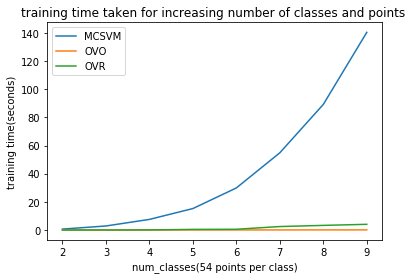

In [98]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(np.array([2, 3, 4, 5, 6, 7, 8, 9]),np.array(trainingTimeTaken), label= 'MCSVM')
ax.plot(np.array([2, 3, 4, 5, 6, 7, 8, 9]),np.array(trainingTimeTakenOVO), label= 'OVO')
ax.plot(np.array([2, 3, 4, 5, 6, 7, 8, 9]),np.array(trainingTimeTakenOVR), label= 'OVR')
ax.legend(loc=0) # upper left corner
ax.set_xlabel('num_classes(54 points per class)')
ax.set_ylabel('training time(seconds)')
ax.set_title('training time taken for increasing number of classes and points ');

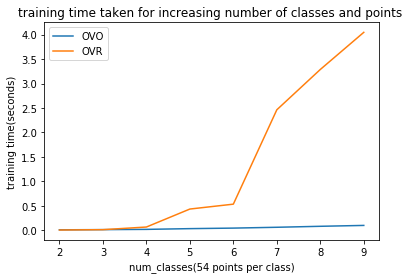

In [99]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

#ax.plot(np.array([2, 3, 4, 5, 6, 7, 8, 9]),np.array(trainingTimeTaken), label= 'MCSVM')
ax.plot(np.array([2, 3, 4, 5, 6, 7, 8, 9]),np.array(trainingTimeTakenOVO), label= 'OVO')
ax.plot(np.array([2, 3, 4, 5, 6, 7, 8, 9]),np.array(trainingTimeTakenOVR), label= 'OVR')
ax.legend(loc=0) # upper left corner
ax.set_xlabel('num_classes(54 points per class)')
ax.set_ylabel('training time(seconds)')
ax.set_title('training time taken for increasing number of classes and points ');


 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.4601e+09 -1.0032e+12  2e+12  4e-01  7e-09
 1:  4.0720e+09 -1.9644e+11  4e+11  7e-02  2e-08
 2:  3.0400e+09 -2.7491e+10  5e+10  9e-03  3e-09
 3:  1.0717e+09 -2.6938e+09  5e+09  6e-04  5e-10
 4:  2.2365e+08 -2.4763e+08  5e+08  5e-06  1e-10
 5:  3.2516e+07 -3.5894e+07  7e+07  2e-16  6e-11
 6:  4.6598e+06 -5.1323e+06  1e+07  2e-16  3e-11
 7:  6.6738e+05 -7.3542e+05  1e+06  2e-16  1e-11
 8:  9.5466e+04 -1.0553e+05  2e+05  2e-16  4e-12
 9:  1.3614e+04 -1.5189e+04  3e+04  2e-16  1e-12
10:  1.9251e+03 -2.2020e+03  4e+03  2e-16  5e-13
11:  2.6566e+02 -3.2548e+02  6e+02  2e-16  2e-13
12:  3.3670e+01 -5.0746e+01  8e+01  2e-16  7e-14
13:  2.5078e+00 -9.2594e+00  1e+01  2e-16  3e-14
14: -2.5167e-01 -5.7914e+00  6e+00  2e-16  2e-14
15: -2.1577e+00 -5.7422e+00  4e+00  2e-16  6e-14
16: -3.2700e+00 -3.8877e+00  6e-01  2e-16  6e-14
17: -3.3274e+00 -3.9179e+00  6e-01  2e-16  5e-14
18: -3.5884e+00 -3.7691e+00  2e-01  2e-16  5e-14
19: -3.6517e+00 -3.6


col_0   0   1   2   3
row_0                
0      22   0   0   0
1       0  18   0   0
2       0   0  23   0
3       0   0   0  20
(33040,)
(33040,)

 Calculating prediction values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

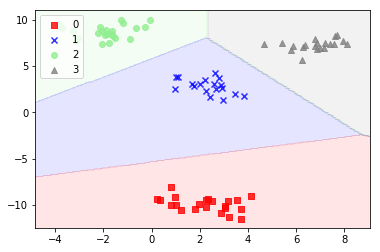

In [7]:
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3)
X1, Y1 = make_blobs(n_features=2, centers=4)
#X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
ran = np.random.rand(len(X1)) < 0.8
train_X_data = X1[ran]
train_Y_data = Y1[ran]
val_X_data = X1[~ran]
val_Y_data = Y1[~ran]
kernel = 'linear'
degree = 4
sigma = 0.4
C = 100000
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
print(conMatrix)
classifier = a1
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)


col_0   0   1   2   3
row_0                
0      22   0   0   0
1       0  18   0   0
2       0   0  23   0
3       0   0   0  20
(33040,)
(33040,)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

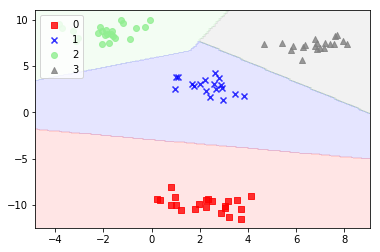

In [8]:
from sklearn import svm
clf = svm.SVC(gamma=1, decision_function_shape='ovo',kernel='linear',degree = 1,C=100000)
clf.fit(train_X_data, train_Y_data) 
predictedLabelVector = []
GivenData = train_X_data
GivenDataLabels = train_Y_data
for i in tqdm(range(0,len(GivenData))):
    predictedLabelVector.append(clf.predict(GivenData[i,:].reshape(1,train_X_data.shape[1])))
conMatrix = pd.crosstab(np.array(predictedLabelVector).ravel(),GivenDataLabels.reshape(-1,1).ravel())
print(conMatrix)
classifier = clf 
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)

C:\Users\sravani\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



col_0   0   1   2   3
row_0                
0      20   0   0   0
1       2  18   0   0
2       0   0  23   0
3       0   0   0  20
(40610,)
(40610,)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

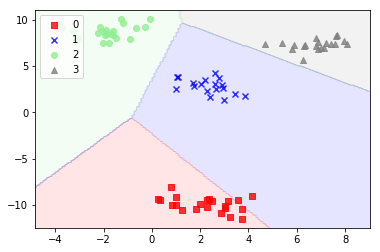

In [11]:
lin_clf = svm.LinearSVC()
lin_clf.C =100000
lin_clf.kernel='linear'
lin_clf.gamma=1
lin_clf.degree=1
lin_clf.max_iter=10**5
lin_clf.fit(train_X_data, train_Y_data) 
predictedLabelVector = []
GivenData = train_X_data
GivenDataLabels = train_Y_data
for i in tqdm(range(0,len(GivenData))):
    predictedLabelVector.append(lin_clf.predict(GivenData[i,:].reshape(1,train_X_data.shape[1])))
conMatrix = pd.crosstab(np.array(predictedLabelVector).ravel(),GivenDataLabels.reshape(-1,1).ravel())
print(conMatrix)
classifier = lin_clf 
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.09)